<a href="https://colab.research.google.com/github/rajeevnair676/NLP_projects/blob/main/IMDB_review_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
df=pd.read_csv('/content/drive/MyDrive/NLP/NLP_projects/Classification/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], stratify=df['sentiment'],
                                                    test_size=0.33,
                                                    shuffle=True, 
                                                    random_state=42)

In [6]:
train = pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)

##<b> Initial EDA on the data

We determine the following from the data:

1. Number of samples
2. Number of classes
3. Number of samples per class
4. Number of words per sample
5. Frequency distribution of words
6. Distribution of sample length

### 1. Number of samples

In [7]:
print(f"The data has {df.shape[0]} rows and {df.shape[1]} columns")

The data has 50000 rows and 2 columns


### 2. Number of classes

In [8]:
print(f"The number of classes on the data are {df.sentiment.unique()}")

The number of classes on the data are ['positive' 'negative']


### 3. Number of samples per class

In [9]:
print(f"The distribution of the classes are: \n{df.sentiment.value_counts()}")

The distribution of the classes are: 
positive    25000
negative    25000
Name: sentiment, dtype: int64


### 4. Number of words per sample

In [10]:
len_list = [len(str(s).split()) for s in train.review]

In [11]:
print(f"The median number of words per sample is {np.median(len_list)}")

The median number of words per sample is 173.0


### 5. Frequency distribution of words

In [12]:
# count = Counter([str(s).split() for s in df.review])

In [13]:
corpus = ' '.join(word for word in train.review)

In [14]:
count = Counter([reviews for reviews in corpus.split()])

In [15]:
count_df = pd.DataFrame(count.most_common(10))
count_df.columns=['word','count']
count_df.style.background_gradient(cmap='Purples')

,word,count
0,the,379870
1,a,205142
2,and,201778
3,of,189378
4,to,174971
5,is,135753
6,in,113152
7,I,88909
8,that,84697
9,this,76045


### 6. Distribution of sample length

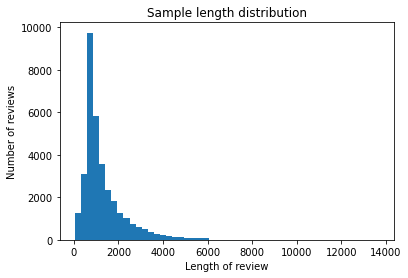

In [16]:
plt.hist([len(s) for s in train.review],50)
plt.xlabel('Length of review')
plt.ylabel('Number of reviews')
plt.title('Sample length distribution')
plt.show()

We see that the frequency distribution is mostly stop words, hence we will remove the stopwords to get a more better representation of the keywords in the corpus

## <b> Cleaning the text

In [17]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stop_words = stopwords.words('english')

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<br />',' ',text)
    text = re.sub(r'[^A-Za-z0-9]',' ',text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [20]:
train['cleaned_review']=train.review.apply(lambda s:clean_text(s))
test['cleaned_review']=test.review.apply(lambda s:clean_text(s))

In [21]:
train.head()

,review,sentiment,cleaned_review
44272,"Sure, it had some of the makings of a good fil...",negative,sure makings good film storyline good bit blan...
33427,This mini-series is iconic of the Australian s...,positive,mini series iconic australian spirit may perha...
36331,When you see the cover of the DVD you're convi...,positive,see cover dvd convinced class b cheesy cheapie...
25718,"When I saw this ""documentary"", I was disappoin...",negative,saw documentary disappointed see serbian propa...
40140,Abysmal Indonesian action film from legendary ...,negative,abysmal indonesian action film legendary ariza...


Now, let's check the frequency distribution on the cleaned corpus

In [22]:
cleaned_corpus=' '.join(word for word in train.cleaned_review)

In [23]:
count_clean = Counter([word for word in cleaned_corpus.split()])

In [24]:
ccount_df = pd.DataFrame(count_clean.most_common(10))
ccount_df.columns=['word','count']
ccount_df.style.background_gradient(cmap='magma_r')

,word,count
0,movie,58892
1,film,53395
2,one,35926
3,like,26648
4,good,19910
5,time,16788
6,even,16622
7,would,16501
8,story,15594
9,really,15421


### Frequency Distribution of Negative Reviews

In [25]:
neg_reviews = train[train['sentiment']=='negative']
pos_reviews = train[train['sentiment']=='positive']

In [26]:

neg_corpus = ' '.join(word for word in neg_reviews.cleaned_review)
count_nclean = Counter([word for word in neg_corpus.split()])
ncount_df = pd.DataFrame(count_nclean.most_common(10))
ncount_df.columns=['word','count']
ncount_df.style.background_gradient(cmap='PuBu')

,word,count
0,movie,33569
1,film,24956
2,one,17594
3,like,15021
4,even,10213
5,bad,9994
6,good,9876
7,would,9394
8,really,8258
9,time,8224


### Frequency Distribution of Positive Reviews

In [27]:
pos_corpus = ' '.join(word for word in pos_reviews.cleaned_review)
count_pclean = Counter([word for word in pos_corpus.split()])
pcount_df = pd.DataFrame(count_pclean.most_common(10))
pcount_df.columns=['word','count']
pcount_df.style.background_gradient(cmap='Oranges')

,word,count
0,film,28439
1,movie,25323
2,one,18332
3,like,11627
4,good,10034
5,story,8709
6,great,8622
7,time,8564
8,well,8453
9,see,8152


We can't see much of trends from the frequency distributions of negative and positive reviews

##<b> Train-validation split

In [28]:
lb=LabelBinarizer()
train['sentiment']=lb.fit_transform(train['sentiment'])
test['sentiment']=lb.transform(test['sentiment'])

In [53]:
y_test=lb.transform(y_test)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_review'], train['sentiment'], test_size=0.2, random_state=333)

##<b> BOW and TFIDF

In [30]:
cv = CountVectorizer(max_df=0.9,min_df=2,ngram_range=(1,3),stop_words=stop_words)
X_train_bow = cv.fit_transform(X_train)

In [31]:
X_val_bow = cv.transform(X_val)

In [32]:
X_test_bow = cv.transform(X_test)

In [33]:
X_train_bow

<26800x449849 sparse matrix of type '<class 'numpy.int64'>'
	with 4340889 stored elements in Compressed Sparse Row format>

In [45]:
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,ngram_range=(1,3),stop_words=stop_words)
X_train_tfidf = tfidf.fit_transform(X_train)

In [46]:
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

## <b> Building models on BOW

###1. Logistic Regression

In [34]:
lr=LogisticRegression(max_iter=1000)
lr_fit = lr.fit(X_train_bow,y_train)

In [35]:
pred_lr = lr.predict(X_val_bow)

In [36]:
pred_lr = lr.predict(X_val_bow)

In [37]:
accuracy_score(y_val,pred_lr)

0.8913432835820896

### 2. MLP Classifier

In [40]:
mlp = MLPClassifier()
mlp.fit(X_train_bow,y_train)

pred_mlp = mlp.predict(X_val_bow)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [41]:
accuracy_score(y_val,pred_mlp)

0.9007462686567164

### 3. Gradient Boosting

In [42]:
gb=GradientBoostingClassifier()
gb.fit(X_train_bow,y_train)

pred_gb = gb.predict(X_val_bow)

In [43]:
accuracy_score(y_val,pred_gb)

0.8071641791044776

## <b>Building models on TFIDF

### 1. Logistic Regression

In [47]:
lr=LogisticRegression(max_iter=1000)
lr_fit = lr.fit(X_train_tfidf,y_train)

In [48]:
pred_lr_tfidf = lr.predict(X_val_tfidf)

In [49]:
accuracy_score(y_val,pred_lr_tfidf)

0.8877611940298508

In [50]:
gb=GradientBoostingClassifier()
gb.fit(X_train_tfidf,y_train)

pred_gb_tfidf = gb.predict(X_val_tfidf)

In [51]:
accuracy_score(y_val,pred_gb_tfidf)

0.8091044776119403

## <b>Evaluation on Test set

In [54]:
test_pred_lr=lr.predict(X_test_tfidf)
accuracy_score(y_test,test_pred_lr)

0.891090909090909

In [55]:
test_pred_gb_tfidf = gb.predict(X_test_tfidf)
accuracy_score(y_test,test_pred_gb_tfidf)

0.808060606060606